<a href="https://colab.research.google.com/github/farhan1503001/Deep-Learning-Rhyme-Projects/blob/main/GradCAM_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GradCAM - Gradient Class Activation Map

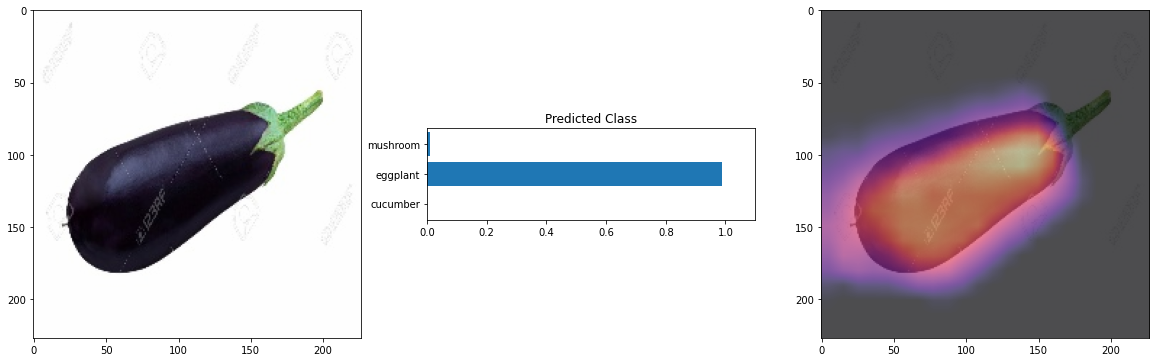

In [48]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

fatal: destination path 'GradCAM-Dataset' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-t2mdoomn
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-t2mdoomn
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [49]:
#Defining system path
import sys
sys.path.append('/content/GradCAM-Dataset')

In [50]:
#importing libraries and essential packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as plt

#Now importing dataloader and other stuffs
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets,transforms as T

#Now importing tqdm and other libraries
from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [51]:
#Now setting up important parameters
CSV_FILE='/content/GradCAM-Dataset/train.csv'
DATA_DIR='/content/GradCAM-Dataset/'

DEVICE='cuda'
LR=0.001
EPOCHS=40
BATCH_SIZE=8

In [52]:
#Now reading data
data=pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


**Splitting dataset into train and validation**

In [53]:
#Class labels eggplant-1 mushroom 2 cucumber 0
train_df,valid_df=train_test_split(data,test_size=0.20,random_state=42)

# Augmentations

In [54]:
train_augs=A.Compose(
    [
        A.Rotate(),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]
)

valid_augs=A.Compose(
    [
        A.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]
)

# Load Image Dataset 

In [55]:
class ImageDataset(Dataset):
  def __init__(self,df,data_dir=None,augs=None,):
    self.df=df
    self.augs=augs
    self.data_dir=data_dir

  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]

    img_path=self.data_dir+row.img_path
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    label=row.label  #Find the label of image

    if self.augs:
      data=self.augs(image=img)
      img=data['image']
    img=torch.from_numpy(img).permute(2,0,1)
    return img,label 

In [56]:
trainset=ImageDataset(train_df,augs=train_augs,data_dir=DATA_DIR)
validset=ImageDataset(valid_df,augs=valid_augs,data_dir=DATA_DIR)

In [57]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


Text(0.5, 1.0, 'eggplant')

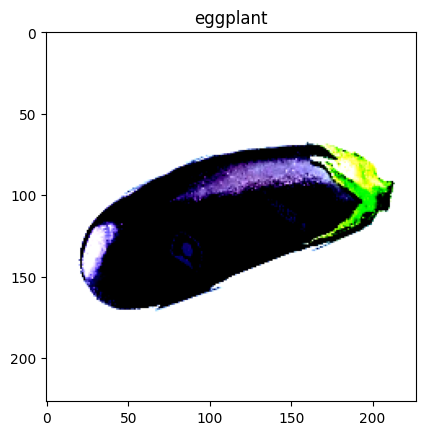

In [58]:
#Showing image and label
import matplotlib.pyplot as plotter
image,label=trainset[0]
classlist=['Cucumber','eggplant','Mashroom']
plotter.imshow(image.permute(1,2,0))
plotter.title(classlist[label])

# Load Dataset into Batches

In [59]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE,shuffle=False)

In [60]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 19
No. of batches in validloader : 5


In [61]:
for images,labels in trainloader:
  break
print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([8, 3, 227, 227])
One batch label shape : torch.Size([8])


# Create Model 

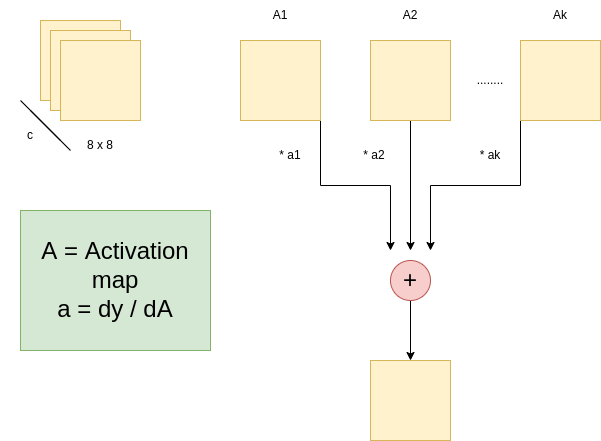

In [62]:
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel,self).__init__()

    self.extractor=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(5,5),padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4),stride=2),
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(5,5),padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4),stride=2),
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(5,5),padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4),stride=2),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5),padding=1),
        nn.ReLU()

    )
    self.maxpool=nn.MaxPool2d(kernel_size=(4,4),stride=2)

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=6400,out_features=2048),
        nn.ReLU(),
        nn.Linear(in_features=2048,out_features=3)
    )
    self.gradient=None

  def activations_hook(self,grad):
    self.gradient=grad

  def forward(self,images):
    x=self.extractor(images)
    #Now registering hooks
    h=x.register_hook(self.activations_hook)
    x=self.maxpool(x)
    x=self.classifier(x)

    return x
  #Now writing getter functions for getting activations hook
  def get_activations_hook(self): #a1,a2,a3
    return self.gradient

  def get_activations(self,x):
    return self.extractor(x)
#Now we will write hooks for picking up gradient
  



In [63]:
model=ImageModel()
model.to(DEVICE)

ImageModel(
  (extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [64]:
#Now writing training and evaluation function
def train_function(dataloader,model,optimizer,criterion):
  model.train()
  total_loss=0.0
  for images,labels in tqdm(dataloader):
    images=images.to(DEVICE)
    labels=labels.to(DEVICE)

    optimizer.zero_grad()
    logits=model(images)
    loss=criterion(logits,labels)
    loss.backward()
    optimizer.step()

  total_loss+=loss.item()
  return total_loss/len(dataloader)

In [65]:
def valid_function(dataloader,model,criterion):
  model.eval()
  total_loss=0.0
  for images,labels in tqdm(dataloader):
    images=images.to(DEVICE)
    labels=labels.to(DEVICE)
    logits=model(images)
    loss=criterion(logits,labels)

    total_loss+=loss.item()
  return total_loss/len(dataloader)

# Training Loop

In [66]:
#Now setting up optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=LR)
criterion=torch.nn.CrossEntropyLoss()

In [67]:
#Now writing training loop
best_valid_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_function(trainloader,model,optimizer,criterion)
  valid_loss=valid_function(validloader,model,criterion)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    best_valid_loss=valid_loss
    print("Best Model Saved")

  print(f"Epoch{i+1}/{EPOCHS} train_loss: {train_loss} valid_loss: {valid_loss}")


100%|██████████| 5/5 [00:00<00:00, 58.73it/s]


Best Model Saved
Epoch1/40 train_loss: 0.05754884920622173 valid_loss: 1.0998984575271606


100%|██████████| 5/5 [00:00<00:00, 35.45it/s]


Best Model Saved
Epoch2/40 train_loss: 0.05124489884627493 valid_loss: 1.044580888748169


100%|██████████| 5/5 [00:00<00:00, 45.36it/s]


Best Model Saved
Epoch3/40 train_loss: 0.037257495679353415 valid_loss: 0.5967696130275726


100%|██████████| 5/5 [00:00<00:00, 63.81it/s]


Epoch4/40 train_loss: 0.038845727318211606 valid_loss: 0.6957448244094848


100%|██████████| 5/5 [00:00<00:00, 57.04it/s]


Epoch5/40 train_loss: 0.027397158898805316 valid_loss: 0.6933061242103576


100%|██████████| 5/5 [00:00<00:00, 59.17it/s]


Best Model Saved
Epoch6/40 train_loss: 0.012379540424597891 valid_loss: 0.5176829099655151


100%|██████████| 5/5 [00:00<00:00, 54.29it/s]


Best Model Saved
Epoch7/40 train_loss: 0.03141985755217703 valid_loss: 0.43243143558502195


100%|██████████| 5/5 [00:00<00:00, 63.03it/s]


Best Model Saved
Epoch8/40 train_loss: 0.02141149263632925 valid_loss: 0.3827037841081619


100%|██████████| 5/5 [00:00<00:00, 39.88it/s]


Epoch9/40 train_loss: 0.006461934039467259 valid_loss: 0.5587623283267021


100%|██████████| 5/5 [00:00<00:00, 36.91it/s]


Epoch10/40 train_loss: 0.01107886668882872 valid_loss: 0.43037129323929546


100%|██████████| 5/5 [00:00<00:00, 42.01it/s]


Best Model Saved
Epoch11/40 train_loss: 0.049803382471988074 valid_loss: 0.2540002532303333


100%|██████████| 5/5 [00:00<00:00, 57.21it/s]


Best Model Saved
Epoch12/40 train_loss: 0.0007265713065862656 valid_loss: 0.21374579668045043


100%|██████████| 5/5 [00:00<00:00, 61.49it/s]


Epoch13/40 train_loss: 0.0009045851858038651 valid_loss: 0.23072680924087763


100%|██████████| 5/5 [00:00<00:00, 60.97it/s]


Epoch14/40 train_loss: 0.016639812996512966 valid_loss: 0.21393326288089157


100%|██████████| 5/5 [00:00<00:00, 35.48it/s]


Best Model Saved
Epoch15/40 train_loss: 0.0014147233021886724 valid_loss: 0.2076778382062912


100%|██████████| 5/5 [00:00<00:00, 25.99it/s]


Best Model Saved
Epoch16/40 train_loss: 0.023479605975903962 valid_loss: 0.15560244619846345


100%|██████████| 5/5 [00:00<00:00, 24.72it/s]


Epoch17/40 train_loss: 0.04505434789155659 valid_loss: 0.29197642803192136


100%|██████████| 5/5 [00:00<00:00, 27.41it/s]


Best Model Saved
Epoch18/40 train_loss: 0.0013187751173973083 valid_loss: 0.06716447267681361


100%|██████████| 5/5 [00:00<00:00, 35.77it/s]


Epoch19/40 train_loss: 0.00015489453155743447 valid_loss: 0.12193052601069213


100%|██████████| 5/5 [00:00<00:00, 37.06it/s]


Epoch20/40 train_loss: 0.015512281342556602 valid_loss: 0.07403259305283427


100%|██████████| 5/5 [00:00<00:00, 38.62it/s]


Best Model Saved
Epoch21/40 train_loss: 1.7462148159546287e-05 valid_loss: 0.029266308271326126


100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


Epoch22/40 train_loss: 0.01305678643678364 valid_loss: 0.6216568533331156


100%|██████████| 5/5 [00:00<00:00, 18.19it/s]


Epoch23/40 train_loss: 0.030799128507312975 valid_loss: 0.40829405318945644


100%|██████████| 5/5 [00:00<00:00, 25.57it/s]


Epoch24/40 train_loss: 6.0027391698799636e-05 valid_loss: 0.12978062639012933


100%|██████████| 5/5 [00:00<00:00, 21.68it/s]


Epoch25/40 train_loss: 0.0006606520986870715 valid_loss: 0.10893011298030615


100%|██████████| 5/5 [00:00<00:00, 20.65it/s]


Epoch26/40 train_loss: 0.14811916100351433 valid_loss: 0.08124875687062741


100%|██████████| 5/5 [00:00<00:00, 42.14it/s]


Epoch27/40 train_loss: 0.01215904951095581 valid_loss: 0.2827172643505037


100%|██████████| 5/5 [00:00<00:00, 35.49it/s]


Epoch28/40 train_loss: 0.002054283493443539 valid_loss: 0.1578372842632234


100%|██████████| 5/5 [00:00<00:00, 17.71it/s]


Epoch29/40 train_loss: 0.0013531293523939031 valid_loss: 0.08175620622932911


100%|██████████| 5/5 [00:00<00:00, 55.88it/s]


Epoch30/40 train_loss: 0.0002731234080305225 valid_loss: 0.26866284263087437


100%|██████████| 5/5 [00:00<00:00, 61.68it/s]


Epoch31/40 train_loss: 6.589892099758512e-05 valid_loss: 0.1614862445741892


100%|██████████| 5/5 [00:00<00:00, 57.07it/s]


Epoch32/40 train_loss: 0.04061534843946758 valid_loss: 0.22560843713581563


100%|██████████| 5/5 [00:00<00:00, 63.35it/s]


Epoch33/40 train_loss: 0.000706514931823078 valid_loss: 0.2315760925412178


100%|██████████| 5/5 [00:00<00:00, 55.94it/s]


Epoch34/40 train_loss: 0.00013441554466752628 valid_loss: 0.06581133045256138


100%|██████████| 5/5 [00:00<00:00, 59.07it/s]


Epoch35/40 train_loss: 8.820210687669092e-06 valid_loss: 0.509933748934418


100%|██████████| 5/5 [00:00<00:00, 40.51it/s]


Epoch36/40 train_loss: 4.052579415177828e-05 valid_loss: 0.15983346644788982


100%|██████████| 5/5 [00:00<00:00, 42.27it/s]


Epoch37/40 train_loss: 0.003274220188981608 valid_loss: 0.030162329226732253


100%|██████████| 5/5 [00:00<00:00, 41.40it/s]


Epoch38/40 train_loss: 9.631653052852734e-06 valid_loss: 0.03653493275633082


100%|██████████| 5/5 [00:00<00:00, 38.95it/s]


Epoch39/40 train_loss: 0.010147735476493835 valid_loss: 0.057440403930377214


100%|██████████| 5/5 [00:00<00:00, 39.99it/s]

Epoch40/40 train_loss: 0.03546037172016345 valid_loss: 0.058850381942465904


# Get GradCAM

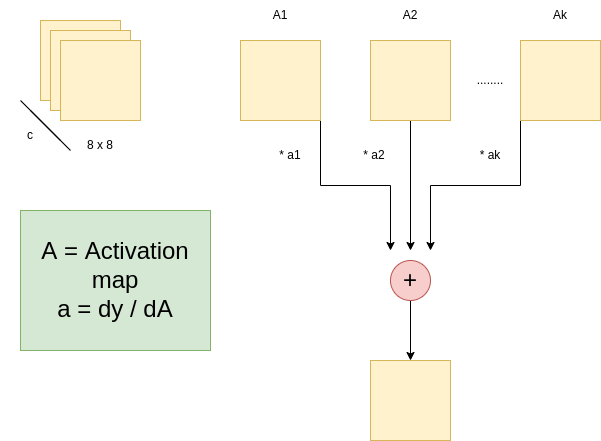

In [68]:
def get_gradcam(model,image,label,size):
  #First backprop
  label.backward()
  #Now we will find out gradients
  gradients=model.get_activations_hook()
  #We have find out a1,a2,a3
  pooled_gradients=torch.mean(gradients,dim=[0,2,3])
  #We are finding out activations
  activations=model.get_activations(image).detach()
  #Now we will multiply for each channel
  for i in range(activations.shape[1]):
    activations[:,i,:,:]*=pooled_gradients[i]

  #Now we will find out heatmap by finding average
  heatmap=torch.mean(activations,dim=1).squeeze().cpu()
  #now send it through RELU
  heatmap=nn.ReLU()(heatmap)
  #Now scale it
  heatmap/=torch.max(heatmap)
  heatmap=cv2.resize(heatmap.numpy(),(size,size))

  return heatmap


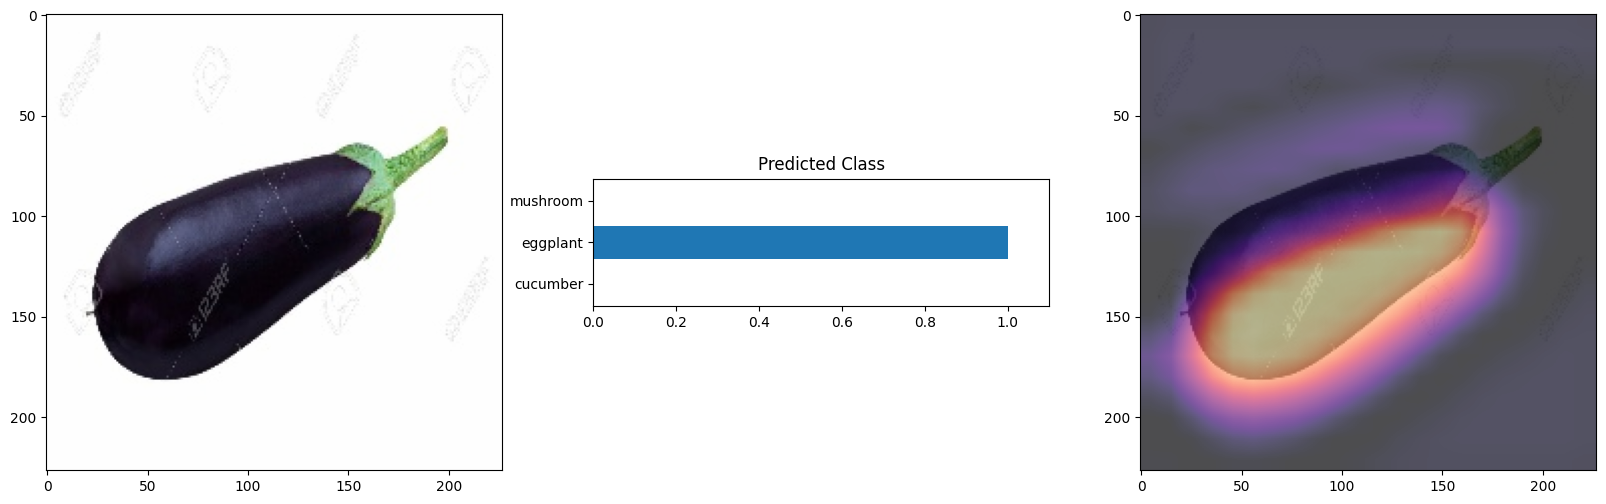

In [72]:
#now visualizing gradcam
image,label=validset[4]
#Now we have to denormalize the image
denorm_image=image.permute(1,2,0)*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
#Now remove the batch dimension
im=image.unsqueeze(0).to(DEVICE)
pred=model(im)
heatmap=get_gradcam(model,im,pred[0][1],size=227)
utils.plot_heatmap(denorm_image,pred,heatmap)